In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, normalized_mutual_info_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import scipy.cluster.hierarchy as shc
from sklearn.neighbors import NearestNeighbors
import time
import gdown
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

dados_sem_outliers = pd.read_csv("SGP_dados_regressão_v3_qc_leq_1.csv")
# Volume de dados
dados_sem_outliers.shape
# Estatística descritiva básica
dados_sem_outliers.describe()
# Exemplo: alvo contínuo com valores negativos
y = dados_sem_outliers['Scattering_Eff']  # seu vetor alvo

# Calculamos o shift para deixar os valores do alvo positivos
min_y = y.min()
eps = 1e-6  # pequeno deslocamento de segurança
shift = -min_y + eps  # garante todos positivos

# Aplicando a transformação log(alvo+1) após fazer shift
y_log = np.log1p(y + shift)
from sklearn.model_selection import train_test_split

# Separação de variáveis preditoras e alvo
X = dados_sem_outliers.drop(['Scattering_Eff'], axis=1) # Características
y = dados_sem_outliers['Scattering_Eff'] # Alvo

y_bins = pd.qcut(y_log, q=25, labels=False, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y_bins)
# Escalonando os preditores X
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Regressão: Gradient Boosting

Agora, de forma similar com o que fizemos para métodos de Random Forest, vamos tentar utilizar nossos dados já condicionados para treinar um modelo de Gradient Boosting.

Vamos começar criando uma regressão preliminar com parâmetros aleatórios do Gradient Boosting para ver quão bem nosso modelo está predizendo

In [ ]:
# Importar o modelo
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Criar o modelo de Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)

# Treinar o modelo
gbr.fit(X_train_s, y_train)

# Fazer previsões
y_pred_train = gbr.predict(X_train_s)
y_pred_test = gbr.predict(X_test_s)

# Avaliar desempenho
print('Regressão Gradient Boosting sem otimização')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão Gradient Boosting sem otimização
Desempenho no conjunto de treino
R^2 =  0.48012528630830975
MSE =  0.3288639504599414
MAE =  0.45946867775875627
Desempenho no conjunto de teste
R^2 =  0.3199521836010235
MSE =  0.43117810128115175
MAE =  0.5217651219079374


Temos um R^2 de treino de 0.33 o que mesmo sem nenhuma otimização de parâmetros já se mostra muito superior do que uma regressão linear múltipla

In [ ]:
# SHAP (SHapley Additive exPlanations)
# Valor absoluto SHAP: indica a importância de cada preditor
# Sinal do SHAP: indica se o preditor contribui para aumento ou diminuição da variável alvo
# Cor: indica como cada preditor influencia no valor da variável alvo
import shap
explainer = shap.TreeExplainer(gbr)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=nomes)

## Otimização dos parâmetros para o Gradient Boosting

Vamos otimizar os hiperparâmetros deste método de ensemble. Para isso, vamos começar fazendo uma randomized search em um grande espaço paramétrico

Essa nossa próxima célula é responsavel por descrever o espaço paramétrico, neste encontraremos uma combinação ótima inicial.

In [ ]:
# Definir o modelo base
gbr = GradientBoostingRegressor(random_state=42)

# Espaço de busca
param_dist = {
    'n_estimators': np.arange(100, 1000, 100),       # número de árvores
    'learning_rate': np.logspace(-2, 0, 10),         # de 0.01 a 1.0
    'max_depth': [2, 3, 4, 5, 6],                   # profundidade das árvores
    'min_samples_split': [2, 5, 10, 20],             # min de amostras p/ split
    'min_samples_leaf': [1, 2, 4, 8],                # min de amostras por folha
    'subsample': [0.6, 0.8, 1.0],                    # fração dos dados usada em cada árvore
    'max_features': ['auto', 'sqrt', None]            # nº de features por árvore
}

In [ ]:
# Randomized Search
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=30,                # número de combinações aleatórias testadas
    cv=4,                     # validação cruzada
    scoring='r2',
    n_jobs=-1,                # usa todos os núcleos do processador
    verbose=2,
    random_state=42
)

# Ajustar o modelo
random_search.fit(X_train_s, y_train)

# Melhor modelo
best_gbr = random_search.best_estimator_
print("Melhores hiperparâmetros:", random_search.best_params_)


Fitting 4 folds for each of 30 candidates, totalling 120 fits
Melhores hiperparâmetros: {'subsample': 0.8, 'n_estimators': np.int64(900), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'learning_rate': np.float64(0.016681005372000592)}


Vamos avaliar novamente como ficam nossas métricas para essa nova combinação de parâmetros

In [ ]:
y_pred_train  = best_gbr.predict(X_train_s)
y_pred_test   = best_gbr.predict(X_test_s)

print('Regressão Gradient Boosting otimizada')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))


Regressão Gradient Boosting otimizada
Desempenho no conjunto de treino
R^2 =  0.7755317227447056
MSE =  0.14199483542277444
MAE =  0.29814785898950397
Desempenho no conjunto de teste
R^2 =  0.40879545668081185
MSE =  0.37484783615216033
MAE =  0.4703429127740666


Temos agora um R^2 de 0.43 para o conjunto de teste o que é um pouco pior do que o do Random Forest, mas ainda melhor do que a regressão linear múltipla, além disso, temos que a mera otimização de parâmetros aumentou o R^2 em 0.1, o que é uma ótima melhoria

Essa é nossa combinação ótima inicial. Agora, a partir dela vamos fazer um grid search para procurar novos valores ótimos em uma malha de parâmetros próxima. Refinando ainda mais os parâmetros

In [ ]:
#{'subsample': 0.8, 'n_estimators': np.int64(900), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'learning_rate': np.float64(0.016681005372000592)}

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [850,950],
    'learning_rate': [0.016681005372000592-0.01,0.016681005372000592+0.01],
    'max_depth': [4,6],
    'min_samples_split': [3,7],
    'min_samples_leaf': [1, 3],
    'subsample': [0.6, 0.8]
}

grid_search = GridSearchCV(
    estimator=random_search.best_estimator_,
    param_grid=param_grid,
    cv=4,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_s, y_train)

print("Melhores parâmetros após o refinamento:", grid_search.best_params_)


Fitting 4 folds for each of 64 candidates, totalling 256 fits
Melhores parâmetros após o refinamento: {'learning_rate': 0.02668100537200059, 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 950, 'subsample': 0.6}


Utilizando os melhores parâmetros encontrados no grid search vamos calcular mais uma vez as métricas para nosso modelo de Gradient Boosting.

In [ ]:
# Criar o modelo de Gradient Boosting
gbr_grid = GradientBoostingRegressor(learning_rate = 0.02668100537200059, max_depth= 6, min_samples_leaf= 3, min_samples_split= 7, n_estimators= 950, subsample = 0.6,random_state=42)

# Treinar o modelo
gbr_grid.fit(X_train_s, y_train)

y_pred_train = gbr_grid.predict(X_train_s)
y_pred_test = gbr_grid.predict(X_test_s)

print('Regressão Gradient Boosting otimizada')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão Gradient Boosting otimizada
Desempenho no conjunto de treino
R^2 =  0.9145639042986213
MSE =  0.054045429031756534
MAE =  0.18033895858086893
Desempenho no conjunto de teste
R^2 =  0.3866017906635769
MSE =  0.38891952720537465
MAE =  0.47664350738619965


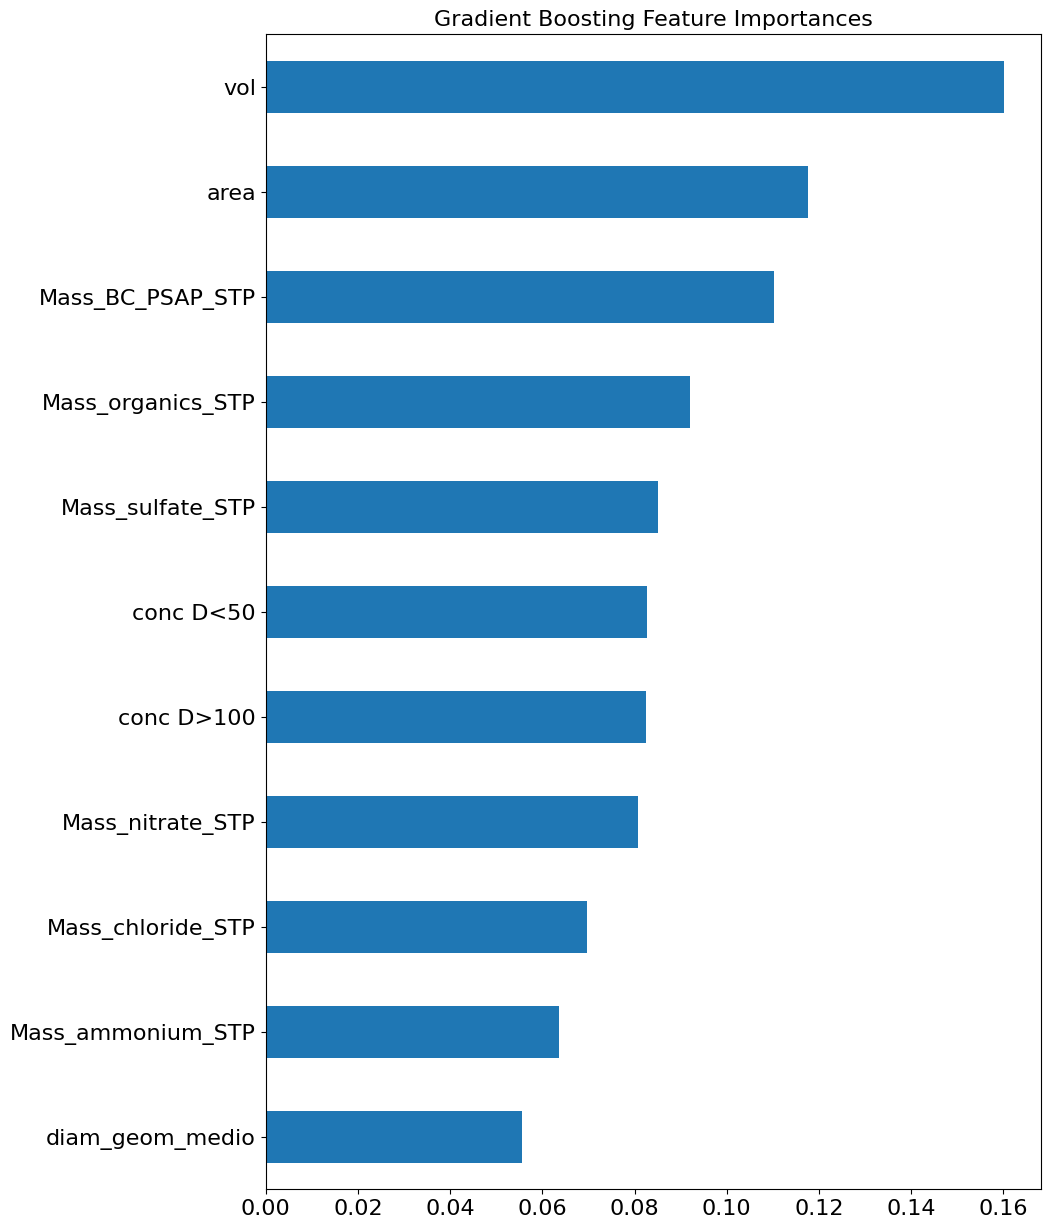

In [ ]:
importances = gbr_grid.feature_importances_
nomes = dados_finais.drop(columns=["Scattering_Eff", "soma_Qc"]).columns
pd.Series(importances, index=nomes).sort_values().plot.barh(figsize = (10,15), fontsize=16)
plt.title("Gradient Boosting Feature Importances", fontsize=16)
plt.show()

Conseguimos por fim um R^2 de 0.473 que é o maior encontrado dentro de todos nossos métodos de regressão.

In [ ]:
# --- R² normal ---
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# --- R² ajustado ---
def r2_adjusted(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# treino
n_train, p = X_train_s.shape
r2_adj_train = r2_adjusted(r2_train, n_train, p)

# teste
n_test, p = X_test_s.shape
r2_adj_test = r2_adjusted(r2_test, n_test, p)

# --- Resultados ---
print(f"R² Ajustado Treino: {r2_adj_train:.4f}")
print(f"R² Ajustado Teste : {r2_adj_test:.4f}")

R² Ajustado Treino: 0.9448
R² Ajustado Teste : 0.4477


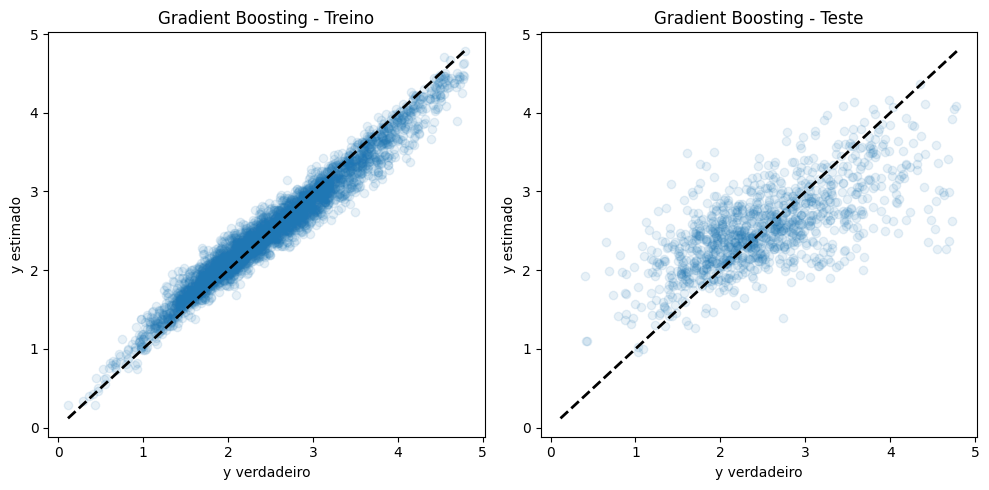

In [ ]:
# Desempenho nos conjuntos de treino e teste
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(y_train, y_pred_train, alpha=.1)
ax[0].set_xlabel('y verdadeiro')
ax[0].set_ylabel('y estimado')
ax[0].set_title('Gradient Boosting - Treino')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2) # 1:1 dashed line

ax[1].scatter(y_test, y_pred_test, alpha=.1)
ax[1].set_xlabel('y verdadeiro')
ax[1].set_ylabel('y estimado')
ax[1].set_title('Gradient Boosting - Teste')
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2) # 1:1 dashed line

plt.tight_layout()

#plt.savefig('/content/drive/MyDrive/Machine Learning/Projeto/gradient_boosting_optimized.png', dpi=150)

plt.show()

## Teste Gradient Boosting para redução de overfitting

### Teste 1:
Número de estimadores: 500 (mais baixo)

learning_rate = 0.23 (mais baixo)

In [ ]:
# Criar o modelo de Gradient Boosting
gbr_grid = GradientBoostingRegressor(learning_rate = 0.02368100537200059, max_depth= 6, min_samples_leaf= 3, min_samples_split= 7, n_estimators= 500, subsample = 0.6)

# Treinar o modelo
gbr_grid.fit(X_train_s, y_train)

y_pred_train = gbr_grid.predict(X_train_s)
y_pred_test = gbr_grid.predict(X_test_s)

print('Regressão Gradient Boosting otimizada')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão Gradient Boosting otimizada
Desempenho no conjunto de treino
R^2 =  0.8388046712200385
MSE =  0.10232748710400917
MAE =  0.251210705385715
Desempenho no conjunto de teste
R^2 =  0.4382729072239666
MSE =  0.35864994420881086
MAE =  0.4584681956318117


In [ ]:
# --- R² normal ---
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# --- R² ajustado ---
def r2_adjusted(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# treino
n_train, p = X_train_s.shape
r2_adj_train = r2_adjusted(r2_train, n_train, p)

# teste
n_test, p = X_test_s.shape
r2_adj_test = r2_adjusted(r2_test, n_test, p)

# --- Resultados ---
print(f"R² Ajustado Treino: {r2_adj_train:.4f}")
print(f"R² Ajustado Teste : {r2_adj_test:.4f}")

R² Ajustado Treino: 0.8383
R² Ajustado Teste : 0.4328


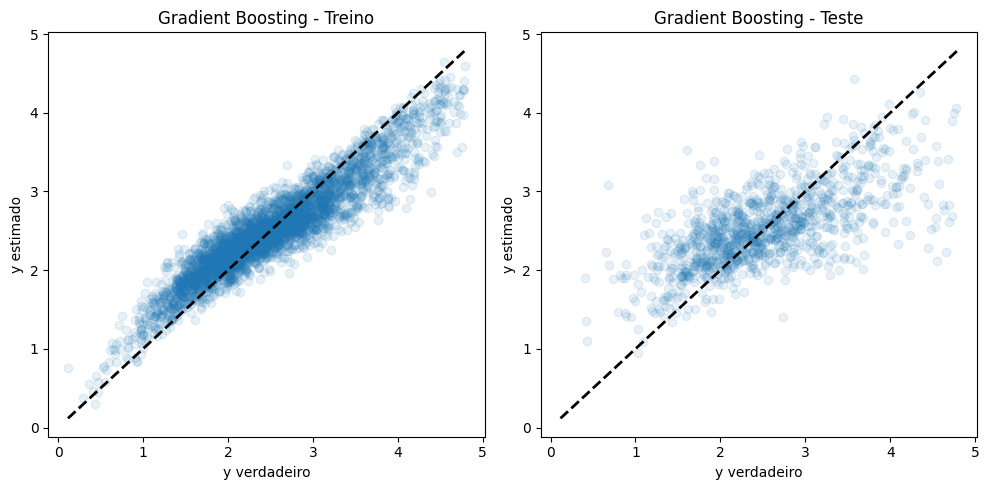

In [ ]:
# Desempenho nos conjuntos de treino e teste
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(y_train, y_pred_train, alpha=.1)
ax[0].set_xlabel('y verdadeiro')
ax[0].set_ylabel('y estimado')
ax[0].set_title('Gradient Boosting - Treino')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2) # 1:1 dashed line

ax[1].scatter(y_test, y_pred_test, alpha=.1)
ax[1].set_xlabel('y verdadeiro')
ax[1].set_ylabel('y estimado')
ax[1].set_title('Gradient Boosting - Teste')
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2) # 1:1 dashed line

plt.tight_layout()

#plt.savefig('/content/drive/MyDrive/Machine Learning/Projeto/gradient_boosting_optimized.png', dpi=150)

plt.show()

### Teste 2:
Número de estimadores: 100 (mais baixo)

learning_rate = 0.23 (mais baixo)

In [ ]:
# Criar o modelo de Gradient Boosting
gbr_grid = GradientBoostingRegressor(learning_rate = 0.02368100537200059, max_depth= 6, min_samples_leaf= 3, min_samples_split= 7, n_estimators= 100, subsample = 0.6)

# Treinar o modelo
gbr_grid.fit(X_train_s, y_train)

y_pred_train = gbr_grid.predict(X_train_s)
y_pred_test = gbr_grid.predict(X_test_s)

print('Regressão Gradient Boosting otimizada')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão Gradient Boosting otimizada
Desempenho no conjunto de treino
R^2 =  0.5410697369292747
MSE =  0.291330902275172
MAE =  0.43637806338719926
Desempenho no conjunto de teste
R^2 =  0.3560810020741474
MSE =  0.4111276020884029
MAE =  0.5053081697945988


In [ ]:
# --- R² normal ---
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# --- R² ajustado ---
def r2_adjusted(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# treino
n_train, p = X_train_s.shape
r2_adj_train = r2_adjusted(r2_train, n_train, p)

# teste
n_test, p = X_test_s.shape
r2_adj_test = r2_adjusted(r2_test, n_test, p)

# --- Resultados ---
print(f"R² Ajustado Treino: {r2_adj_train:.4f}")
print(f"R² Ajustado Teste : {r2_adj_test:.4f}")

R² Ajustado Treino: 0.5397
R² Ajustado Teste : 0.3498


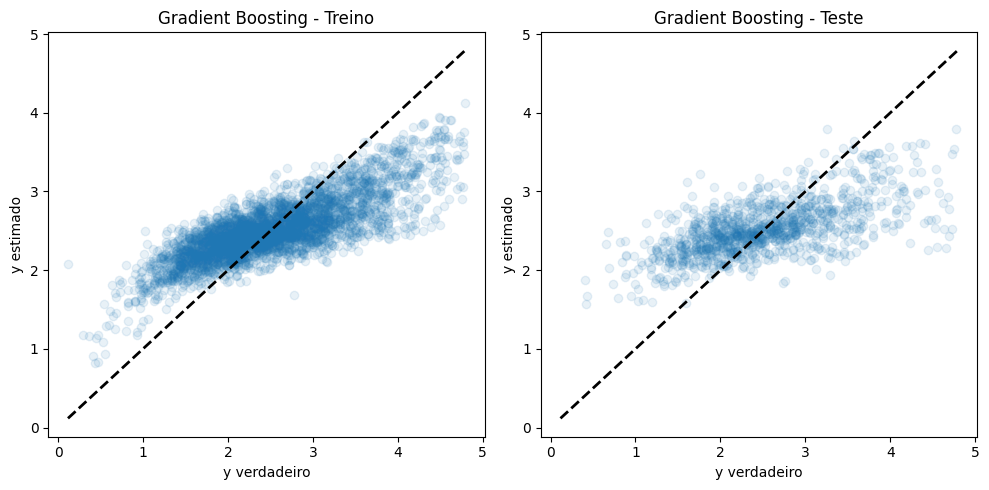

In [ ]:
# Desempenho nos conjuntos de treino e teste
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(y_train, y_pred_train, alpha=.1)
ax[0].set_xlabel('y verdadeiro')
ax[0].set_ylabel('y estimado')
ax[0].set_title('Gradient Boosting - Treino')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2) # 1:1 dashed line

ax[1].scatter(y_test, y_pred_test, alpha=.1)
ax[1].set_xlabel('y verdadeiro')
ax[1].set_ylabel('y estimado')
ax[1].set_title('Gradient Boosting - Teste')
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2) # 1:1 dashed line

plt.tight_layout()

#plt.savefig('/content/drive/MyDrive/Machine Learning/Projeto/gradient_boosting_optimized.png', dpi=150)

plt.show()

### Teste 3:
Número de estimadores: 250 (mais baixo)

learning_rate = 0.23 (mais baixo)

In [ ]:
# Criar o modelo de Gradient Boosting
gbr_grid = GradientBoostingRegressor(learning_rate = 0.02368100537200059, max_depth= 6, min_samples_leaf= 3, min_samples_split= 7, n_estimators= 250, subsample = 0.6)

# Treinar o modelo
gbr_grid.fit(X_train_s, y_train)

y_pred_train = gbr_grid.predict(X_train_s)
y_pred_test = gbr_grid.predict(X_test_s)

print('Regressão Gradient Boosting otimizada')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão Gradient Boosting otimizada
Desempenho no conjunto de treino
R^2 =  0.7148429516376723
MSE =  0.18101891915704668
MAE =  0.3392693788701887
Desempenho no conjunto de teste
R^2 =  0.4188101217139667
MSE =  0.37107648910414964
MAE =  0.47110171820747837


In [ ]:
# --- R² normal ---
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# --- R² ajustado ---
def r2_adjusted(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# treino
n_train, p = X_train_s.shape
r2_adj_train = r2_adjusted(r2_train, n_train, p)

# teste
n_test, p = X_test_s.shape
r2_adj_test = r2_adjusted(r2_test, n_test, p)

# --- Resultados ---
print(f"R² Ajustado Treino: {r2_adj_train:.4f}")
print(f"R² Ajustado Teste : {r2_adj_test:.4f}")

R² Ajustado Treino: 0.7140
R² Ajustado Teste : 0.4131


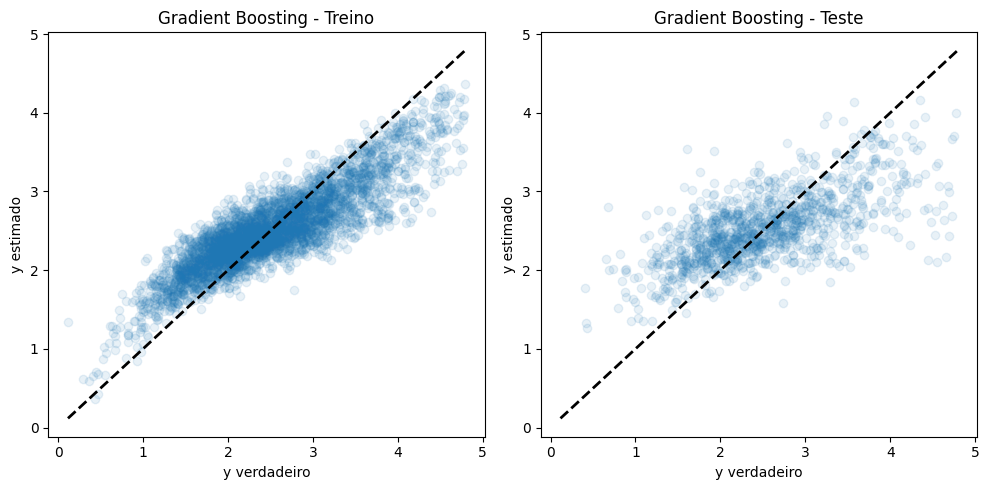

In [ ]:
# Desempenho nos conjuntos de treino e teste
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(y_train, y_pred_train, alpha=.1)
ax[0].set_xlabel('y verdadeiro')
ax[0].set_ylabel('y estimado')
ax[0].set_title('Gradient Boosting - Treino')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2) # 1:1 dashed line

ax[1].scatter(y_test, y_pred_test, alpha=.1)
ax[1].set_xlabel('y verdadeiro')
ax[1].set_ylabel('y estimado')
ax[1].set_title('Gradient Boosting - Teste')
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2) # 1:1 dashed line

plt.tight_layout()

#plt.savefig('/content/drive/MyDrive/Machine Learning/Projeto/gradient_boosting_optimized.png', dpi=150)

plt.show()